In [83]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

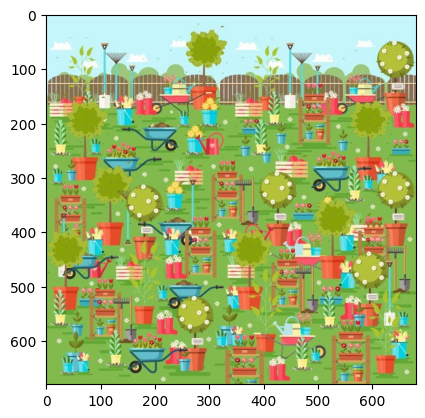

In [84]:
img = cv2.imread('pair_boot.jpg')
plt.imshow(img[:,:,::-1])

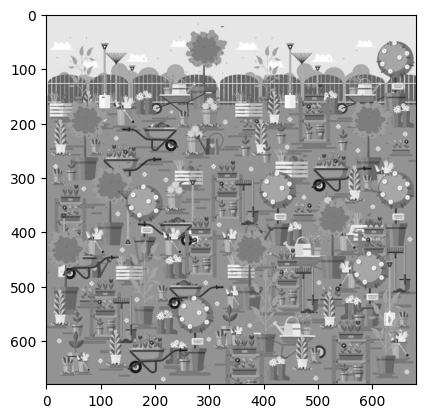

In [85]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

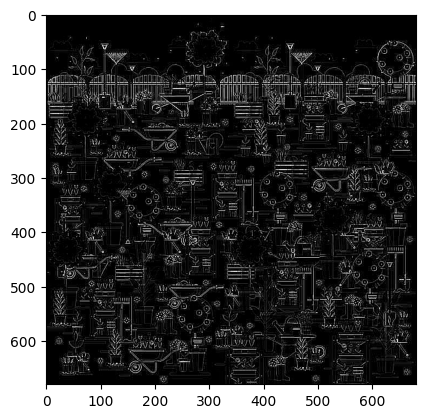

In [86]:
templates = []

kernel = np.array(
    [[1, 1, 1],
     [1, -8, 1],
     [1, 1, 1]]
)
img_conv = cv2.filter2D(img_gray, -1, kernel)
plt.imshow(img_conv, cmap='gray')

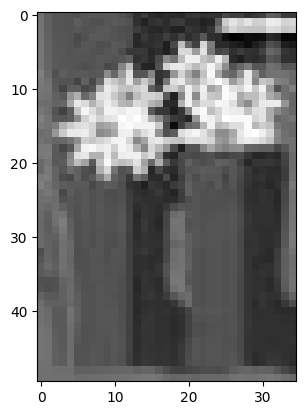

In [87]:
template1 = img_gray[160:210, 635:670]
templates.append(template1)
plt.imshow(template1, cmap='gray')

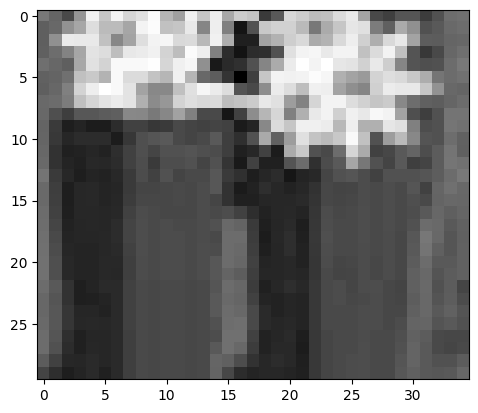

In [88]:
template2 = cv2.flip(template1, 1)
template2 = template2[10:40,:]
templates.append(template2)
plt.imshow(template2, cmap='gray')

In [89]:
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

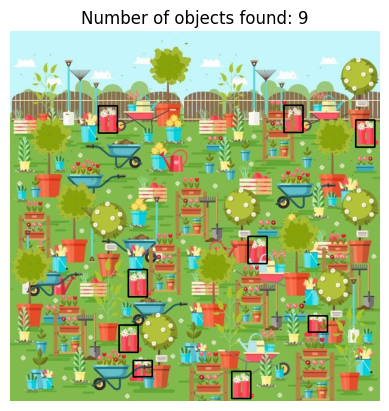

In [90]:
conv_templates = [cv2.filter2D(template, -1, kernel) for template in templates]
heights = [template.shape[0] for template in templates]
widths = [template.shape[1] for template in templates]

img2 = img.copy()
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2_conv = cv2.filter2D(img2_gray, -1, kernel)

rectangles = []

for i, (template, conv_template, h, w) in enumerate(zip(templates, conv_templates, heights, widths)):
    result = cv2.matchTemplate(img2_conv, conv_template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(result >= 0.35)
    
    for pt in zip(*loc[::-1]):
        bottom_right = (pt[0] + w, pt[1] + h)
        rectangles.append([pt[0], pt[1], bottom_right[0], bottom_right[1]])

rectangles = np.array(rectangles)

nms_rectangles = non_max_suppression(rectangles, overlapThresh=0.2)

count = 0
for (x1, y1, x2, y2) in nms_rectangles:
    cv2.rectangle(img2, (x1, y1), (x2, y2), (0, 0, 0), 2)
    count += 1

plt.imshow(img2[:,:,::-1])
plt.title(f'Number of objects found: {count}')
plt.axis('off')
plt.show()